# Convolutional Neural Network, Keras

In [20]:
import numpy as np
import matplotlib.pyplot as plt # to visualize only
import pandas as pd
from sklearn.model_selection import train_test_split

import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import backend as K

In [3]:
x = pd.read_csv("./data/processed_x.csv", delimiter=",", header = None)
x = x.values # dataframe to numpy ndarray
x = x.astype(np.float32)
x /= 255 # normalize

In [5]:
y = pd.read_csv("./data/train_y.csv", delimiter = ",", header = None)
y = (y.values).ravel()

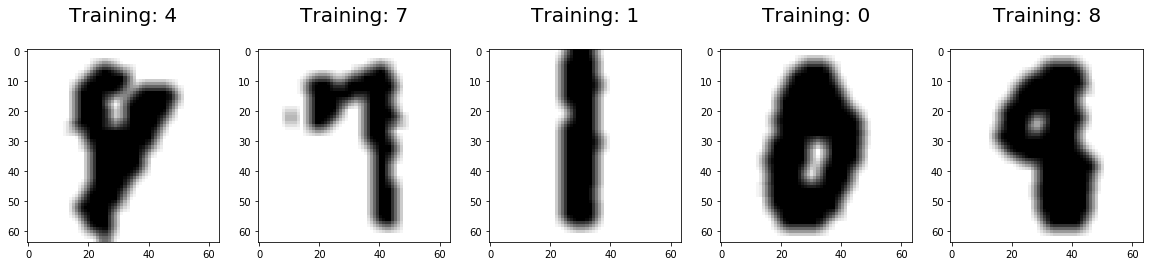

In [6]:
# look at some data for sanity check
def plotter(images, labels, start):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[start:start+5], labels[start:start+5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (64,64)), cmap= 'gray')
        plt.title('Training: %i\n' % label, fontsize = 20)
plotter(x, y, 0) # first 5 images

In [7]:
# split it on up
np.random.seed(100) # for determinism
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=1/10.0, random_state=0)

In [8]:
# set up conv net
batch_size = 128
epochs = 15

num_classes = 10
img_rows, img_cols, = 64, 64

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
# sanity check that all the shapes of the data are correct
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(45000, 64, 64, 1)
(5000, 64, 64, 1)
(45000,)
(5000,)


In [13]:
# construct the image generator for data augmentation
img_data_gen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=12,  # randomly rotate images in the range 0 - 20 degrees
            horizontal_flip=False,  # don't flip images
            vertical_flip=False)

In [14]:
img_data_gen.fit(x_train)

In [10]:
# train an encoder to convert labels to integer labels, one-hot encodings, and back
encoder = LabelEncoder().fit(y.reshape((y.shape[0],)))

def encode_onehot(lab):
    return to_categorical(encoder.transform(lab))

def decode_onehot(lab):
    return encoder.inverse_transform(np.argmax(lab, axis = 1))

In [24]:
# ew magic numbers
model = Sequential()
# changing from (3,3) to (2,2)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=ks.losses.categorical_crossentropy,
              optimizer=ks.optimizers.Adadelta(),
              metrics=['accuracy'])

In [25]:
# go, go, go! go, go speed racer!
model.fit(x_train, encode_onehot(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, encode_onehot(y_valid)))

# model.fit_generator(img_data_gen.flow(x_train, encode_onehot(y_train), batch_size=15),
#         validation_data=(x_valid, encode_onehot(y_valid)), steps_per_epoch=int(len(x_train)/20),
#         epochs=epochs, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 17s 367us/step - loss: 1.2500 - acc: 0.5911 - val_loss: 0.5196 - val_acc: 0.8498
Epoch 2/15
45000/45000 [==============================] - 16s 348us/step - loss: 0.6197 - acc: 0.8265 - val_loss: 0.3772 - val_acc: 0.9008
Epoch 3/15
45000/45000 [==============================] - 16s 346us/step - loss: 0.4893 - acc: 0.8694 - val_loss: 0.3372 - val_acc: 0.9114
Epoch 4/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.4274 - acc: 0.8871 - val_loss: 0.3189 - val_acc: 0.9186
Epoch 5/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.3907 - acc: 0.8968 - val_loss: 0.3242 - val_acc: 0.9158
Epoch 6/15
45000/45000 [==============================] - 16s 345us/step - loss: 0.3640 - acc: 0.9044 - val_loss: 0.2937 - val_acc: 0.9222
Epoch 7/15
45000/45000 [==============================] - 16s 346us/step - loss: 0.3426 - acc: 0.9113 - val_loss: 0.2

In [12]:
score = model.evaluate(x_valid, encode_onehot(y_valid), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2546268650650978
Test accuracy: 0.9364


In [24]:
# testing, 1, 2, testing....
x_test = pd.read_csv("./data/processed_test_x.csv", delimiter=",", header = None)
x_test = x_test.values
x_test = x_test.astype(np.float32)
x_test /= 255
if K.image_data_format() == 'channels_first':
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
else:
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [14]:
predictions = model.predict_classes(x_test)
ids = list(range(len(predictions)))

print(predictions[:100])
output = pd.DataFrame({'Id': ids, 'Label': predictions})
output.to_csv("./data/ConvNetPredictions.csv", header = True, index = False)

[7 2 0 7 6 1 5 3 8 1 5 1 9 1 0 2 3 0 0 3 3 0 6 1 6 0 2 8 2 0 2 8 9 1 8 6 0
 1 0 4 0 7 1 1 0 2 3 6 8 4 9 7 3 9 8 2 2 6 5 9 9 9 3 3 8 8 3 8 9 5 2 4 9 4
 8 5 1 8 1 4 9 4 6 8 3 8 1 9 1 6 3 9 0 2 9 3 9 7 2 4]


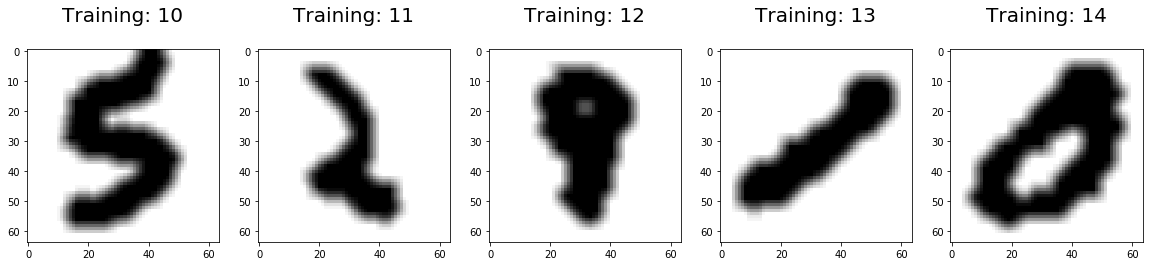

In [18]:
plotter(x_test, ids, 10)

## Trying different architectures and hyperparams

In [11]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))

In [16]:
rfield=5
pool_size=2
model2 = Sequential()
model2.add(Conv2D(8, (rfield, rfield), padding='same', input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(Conv2D(8, (rfield, rfield)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Dropout(0.25))

model2.add(Conv2D(16, (rfield, rfield), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(16, (rfield, rfield), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [49]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(Activation('relu'))
BatchNormalization(axis=-1)
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model3.add(Conv2D(64,(3, 3)))
model3.add(Activation('relu'))
BatchNormalization(axis=-1)
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())

BatchNormalization()
model3.add(Dense(512))
model3.add(Activation('relu'))
BatchNormalization()
model3.add(Dropout(0.5))
model3.add(Dense(10))

model3.add(Activation('softmax'))

In [48]:
# model4 = Sequential()
# model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model4.add(Conv2D(64, (3, 3), activation='relu'))
# model4.add(MaxPooling2D(pool_size=(2, 2)))
# model4.add(Dropout(0.25))
# model4.add(Flatten())
# model4.add(Dense(128, activation='relu'))
# model4.add(Dropout(0.5))
# model4.add(Dense(num_classes, activation='softmax'))

model4 = Sequential()
model4.add(Conv2D(30, (5, 5), input_shape=input_shape, activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Conv2D(15, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.5))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(50, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))

In [ ]:
models = [model1, model2, model3, model4]
histories = []
for m in models:
    m.compile(loss=ks.losses.categorical_crossentropy,
              optimizer=ks.optimizers.Adadelta(),
              metrics=['accuracy'])
    history = m.fit(x_train, encode_onehot(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, encode_onehot(y_valid)))
    histories.append(history)

In [52]:
models2 = [model4]
histories2 = []
for m in models2:
    m.compile(loss=ks.losses.categorical_crossentropy,
              optimizer=ks.optimizers.Adadelta(),
              metrics=['accuracy'])
    history = m.fit(x_train, encode_onehot(y_train),
          batch_size=batch_size,
          epochs=epochs+7,
          verbose=1,
          validation_data=(x_valid, encode_onehot(y_valid)))
    histories2.append(history)

Train on 45000 samples, validate on 5000 samples
Epoch 1/22
45000/45000 [==============================] - 5s 110us/step - loss: 0.1126 - acc: 0.9683 - val_loss: 0.2500 - val_acc: 0.9468
Epoch 2/22
45000/45000 [==============================] - 5s 103us/step - loss: 0.1082 - acc: 0.9692 - val_loss: 0.2423 - val_acc: 0.9466
Epoch 3/22
45000/45000 [==============================] - 5s 101us/step - loss: 0.1041 - acc: 0.9705 - val_loss: 0.2552 - val_acc: 0.9478
Epoch 4/22
45000/45000 [==============================] - 5s 100us/step - loss: 0.1041 - acc: 0.9697 - val_loss: 0.2566 - val_acc: 0.9470
Epoch 5/22
45000/45000 [==============================] - 5s 101us/step - loss: 0.0992 - acc: 0.9713 - val_loss: 0.2597 - val_acc: 0.9462
Epoch 6/22
45000/45000 [==============================] - 5s 103us/step - loss: 0.0954 - acc: 0.9721 - val_loss: 0.2584 - val_acc: 0.9454
Epoch 7/22
45000/45000 [==============================] - 5s 102us/step - loss: 0.0970 - acc: 0.9718 - val_loss: 0.2515 - v

In [25]:
predictions = model2.predict_classes(x_test)
ids = list(range(len(predictions)))

print(predictions[:100])
output = pd.DataFrame({'Id': ids, 'Label': predictions})
output.to_csv("./data/ConvNetPredictions2.csv", header = True, index = False)

[7 2 0 7 6 1 5 3 8 1 5 2 9 1 0 2 3 0 0 3 3 0 6 1 6 0 2 8 3 0 2 8 9 1 8 6 0
 1 3 4 0 7 1 1 0 2 3 6 8 4 9 7 3 9 8 2 2 6 5 9 9 9 3 3 8 8 3 8 9 5 2 4 9 4
 8 3 1 8 1 4 9 4 6 8 3 8 7 7 1 6 3 9 0 2 9 3 9 7 2 4]


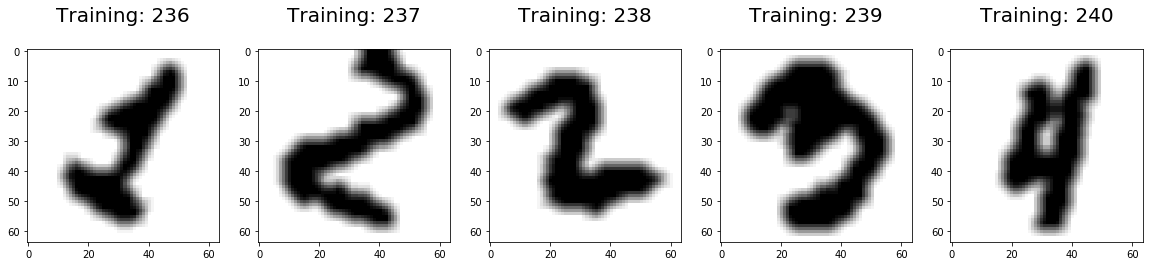

In [35]:
plotter(x_test, ids, 236)

In [37]:
# 94.066 on test! 0_0

rfield=8
pool_size=2
model2 = Sequential()
model2.add(Conv2D(8, (rfield, rfield), padding='same', input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(Conv2D(8, (rfield, rfield)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Dropout(0.25))

model2.add(Conv2D(16, (rfield, rfield), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(16, (rfield, rfield), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10))
model2.add(Activation('softmax'))

model2.compile(loss=ks.losses.categorical_crossentropy,
          optimizer=ks.optimizers.Adadelta(),
          metrics=['accuracy'])
history = model2.fit(x_train, encode_onehot(y_train),
      batch_size=batch_size,
      epochs=epochs+5,
      verbose=1,
      validation_data=(x_valid, encode_onehot(y_valid)))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 8s 186us/step - loss: 0.7567 - acc: 0.7727 - val_loss: 0.3579 - val_acc: 0.9048
Epoch 2/20
45000/45000 [==============================] - 8s 178us/step - loss: 0.3843 - acc: 0.9055 - val_loss: 0.3057 - val_acc: 0.9214
Epoch 3/20
45000/45000 [==============================] - 8s 177us/step - loss: 0.3263 - acc: 0.9214 - val_loss: 0.2393 - val_acc: 0.9368
Epoch 4/20
45000/45000 [==============================] - 8s 177us/step - loss: 0.3034 - acc: 0.9276 - val_loss: 0.2586 - val_acc: 0.9438
Epoch 5/20
45000/45000 [==============================] - 8s 176us/step - loss: 0.2888 - acc: 0.9319 - val_loss: 0.2599 - val_acc: 0.9410
Epoch 6/20
45000/45000 [==============================] - 8s 177us/step - loss: 0.2684 - acc: 0.9376 - val_loss: 0.2567 - val_acc: 0.9348
Epoch 7/20
45000/45000 [==============================] - 8s 177us/step - loss: 0.2615 - acc: 0.9384 - val_loss: 0.2303 - v

In [38]:
predictions = model2.predict_classes(x_test)
ids = list(range(len(predictions)))

print(predictions[:100])
output = pd.DataFrame({'Id': ids, 'Label': predictions})
output.to_csv("./data/ConvNetPredictions3.csv", header = True, index = False)

[7 2 0 7 6 1 5 3 8 1 5 1 9 1 0 2 3 0 0 3 3 0 6 1 4 0 2 8 3 0 2 8 9 1 8 6 0
 1 3 4 0 7 1 1 0 2 3 6 8 4 9 7 3 9 8 2 2 6 5 9 9 9 3 3 8 8 3 8 9 5 2 4 9 4
 8 3 1 8 1 4 9 4 6 8 3 8 7 7 1 6 3 9 0 2 9 3 9 7 2 4]


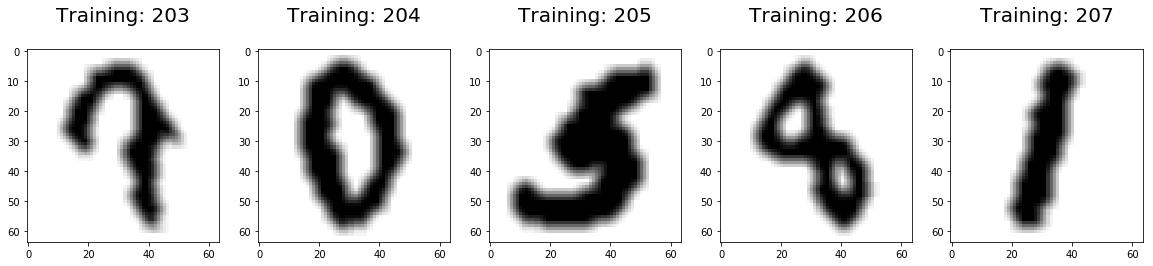

In [47]:
plotter(x_test, ids, 203)

In [53]:
rfield=8
pool_size=2
model5 = Sequential()
model5.add(Conv2D(8, (rfield, rfield), padding='valid', input_shape=input_shape))
model5.add(Activation('relu'))
model5.add(Conv2D(8, (rfield, rfield)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model5.add(Dropout(0.25))

model5.add(Conv2D(16, (rfield, rfield), padding='valid'))
model5.add(Activation('relu'))
model5.add(Conv2D(16, (rfield, rfield), padding='valid'))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(128))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(10))
model5.add(Activation('softmax'))

model5.compile(loss=ks.losses.categorical_crossentropy,
          optimizer=ks.optimizers.Adadelta(),
          metrics=['accuracy'])
history = model5.fit(x_train, encode_onehot(y_train),
      batch_size=batch_size,
      epochs=epochs+5,
      verbose=1,
      validation_data=(x_valid, encode_onehot(y_valid)))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 5s 116us/step - loss: 0.9830 - acc: 0.6910 - val_loss: 0.4152 - val_acc: 0.8836
Epoch 2/20
45000/45000 [==============================] - 5s 102us/step - loss: 0.4888 - acc: 0.8714 - val_loss: 0.3268 - val_acc: 0.9118
Epoch 3/20
45000/45000 [==============================] - 5s 103us/step - loss: 0.4051 - acc: 0.8975 - val_loss: 0.3075 - val_acc: 0.9178
Epoch 4/20
45000/45000 [==============================] - 5s 104us/step - loss: 0.3693 - acc: 0.9078 - val_loss: 0.2929 - val_acc: 0.9250
Epoch 5/20
45000/45000 [==============================] - 5s 103us/step - loss: 0.3490 - acc: 0.9138 - val_loss: 0.2701 - val_acc: 0.9278
Epoch 6/20
45000/45000 [==============================] - 5s 102us/step - loss: 0.3318 - acc: 0.9192 - val_loss: 0.2588 - val_acc: 0.9344
Epoch 7/20
45000/45000 [==============================] - 5s 103us/step - loss: 0.3160 - acc: 0.9215 - val_loss: 0.2592 - v